In [2]:
from research.universal.utils.model_utils import get_attention_layer, get_ff_layer
from research.universal.utils.argparse import introduce_parser_arguments
from lizrd.train.load_and_save_model import get_checkpoint_from_path
from lizrd.text import tokenizers
import argparse
import os
import random
from typing import Callable, Optional
import socket

import torch
import torch.multiprocessing as mp
from torch.distributed import init_process_group, destroy_process_group

from lizrd.core import misc, llm
from lizrd.core.llm import EmbeddingLayer, Parallel
from lizrd.support.logging import get_current_logger, get_logger
from lizrd.support.misc import (
    get_argument_attributes,
    get_n_learnable_parameters,
    set_seed,
)
from lizrd.train.train_utils import (
    get_model,
)

VOCAB_SIZE = (
        tokenizers.GPTTokenizer.VOCAB_SIZE
    )

block_modules = {}
for module_name in ["attention", "feedforward"]:
    if module_name == "attention":
        block_modules[module_name] = lambda: llm.Attention(
        dmodel=1024,
        heads=16,
        causal=True,
        init_type="truncated_normal",
        init_scale=0.1,
        dhead=64,
        flash=False,
    )
    elif module_name == "feedforward":
        block_modules[module_name] = lambda: llm.FeedForward(
        1024, 2048, init_type="truncated_normal", init_scale=0.1
    )
    else:
        raise ValueError(f"Unknown module name: {module_name}")

checkpoint = (
        get_checkpoint_from_path("universal.pt")
    )

model = get_model(
        max_length=256,
        vocab_size=VOCAB_SIZE,
        block_modules=block_modules,
        dm=1024,
        n_blocks=1,
        device=(
            torch.device("cpu")
        ),  # in case of  DDP/FSDP, we initialize the model on CPU and move it to the GPU later
        init_type="truncated_normal",
        init_scale=0.1,
        ddp_enabled=False,
        fsdp_enabled=False,
        fsdp_param_precision=None,
        fsdp_mixed_precision_ignore_classes=[],
        fsdp_offload_params=False,
        fsdp_min_num_params=0,
        fsdp_modules_to_wrap=None,
        activation_checkpointing_modules=None,
        is_logging_process=True,
        checkpoint=checkpoint,
        universal=True,
        n_repeats=8,
    )

Loading checkpoint from universal.pt...
Checkpoint loaded
Loading model weights...
Loaded model weights


In [2]:
text = "Lorem ipsum dolor sit amet"
tokens = tokenizers.GPTTokenizer().text_to_ids(text)
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0)
# double the tokens
tokens = torch.cat([tokens, tokens], dim=1)
model.eval()

LLM(
  (embedding_layer): EmbeddingLayer(
    (layers): ModuleList(
      (0): Embedding(50257, 1024)
      (1): PositionalEmbedding(
        (layer): Embedding(256, 1024)
      )
    )
  )
  (encoder): TransformerTower(
    (blocks): Sequential(
      (block_0): TransformerBlock(
        (block): Sequential(
          (residual_attention): Residual(
            (layer): Sequential(
              (pre_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (attention): Attention(
                (input_projection): Linear(in_features=1024, out_features=3072, bias=False)
                (output_projection): Linear(in_features=1024, out_features=1024, bias=False)
                (attention_mechanism): AttentionMechanism()
              )
            )
          )
          (residual_feedforward): Residual(
            (layer): Sequential(
              (pre_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (feedforward): Sequential(
         

torch.Size([16, 20, 20])


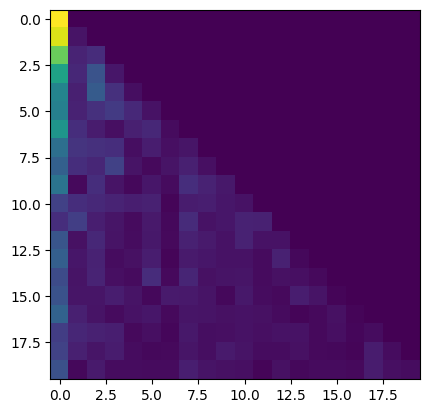

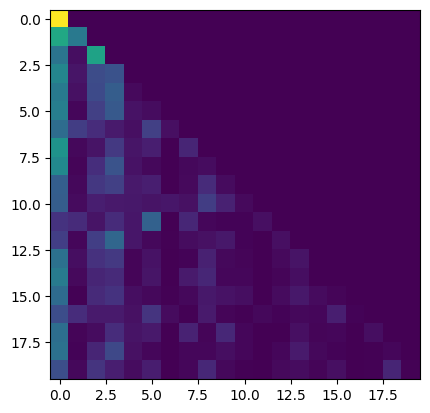

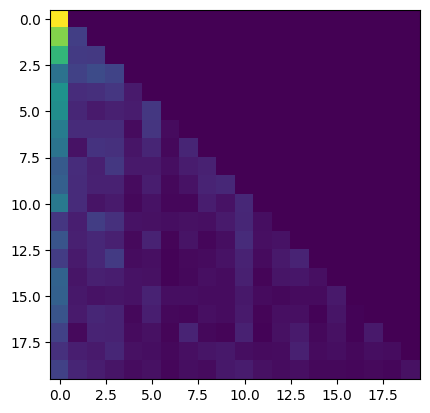

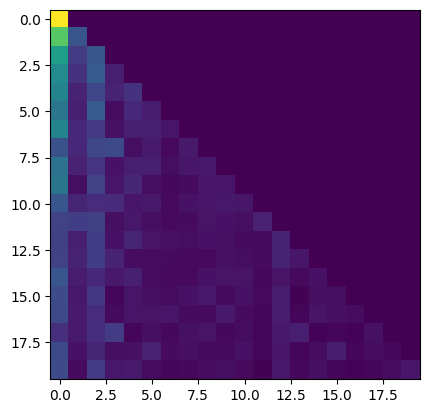

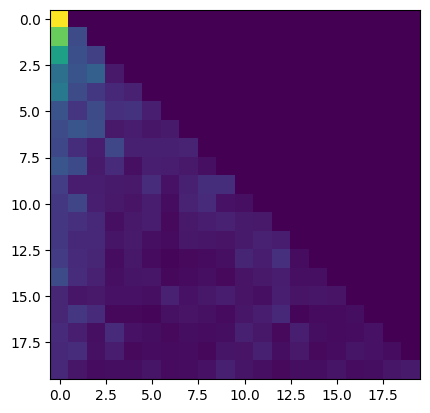

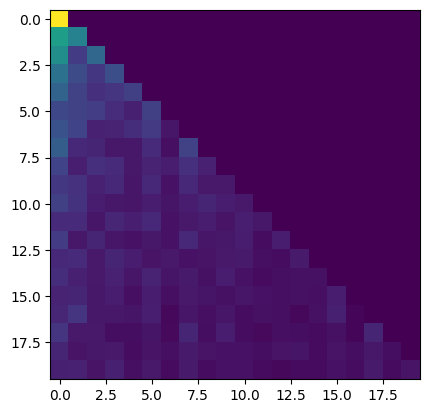

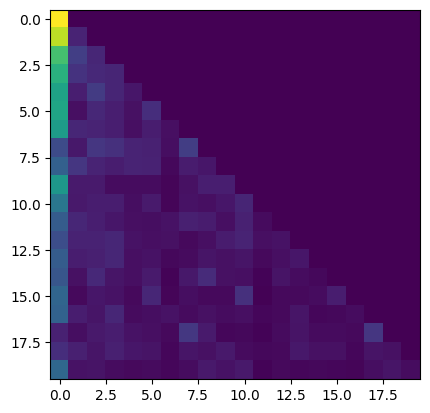

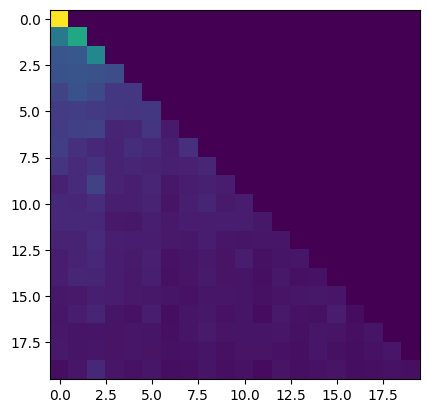

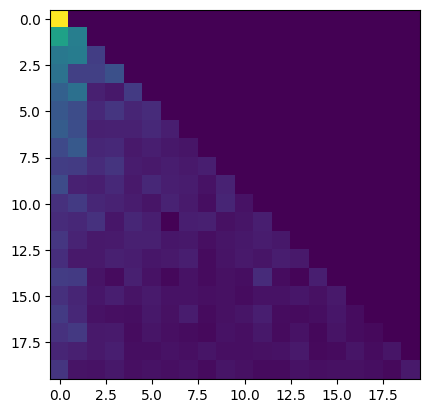

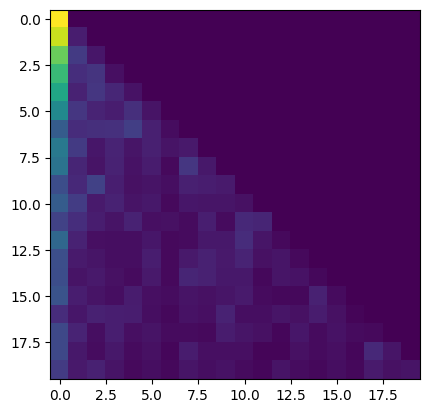

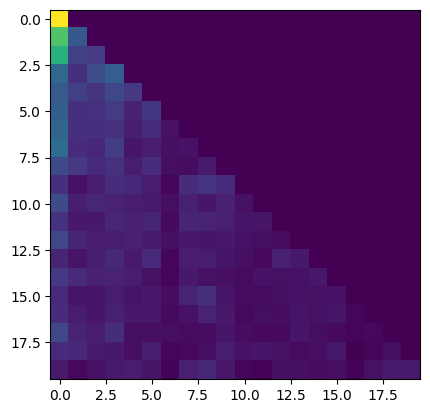

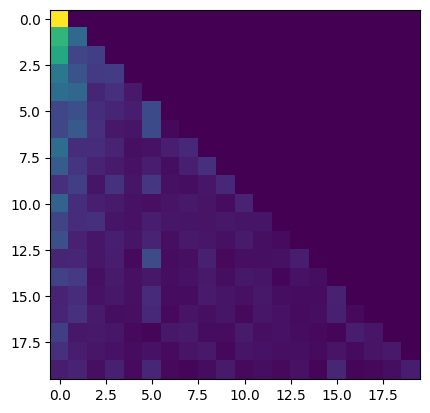

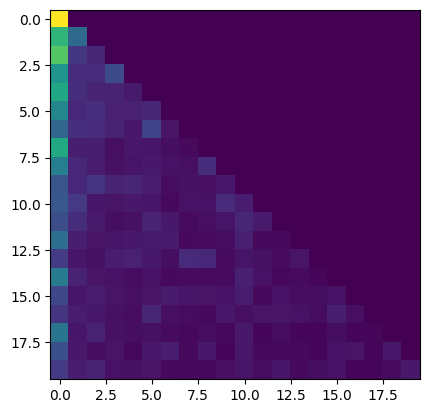

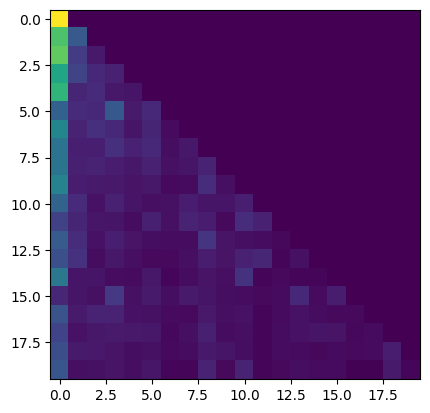

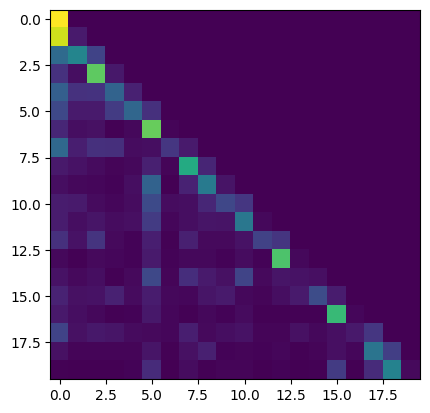

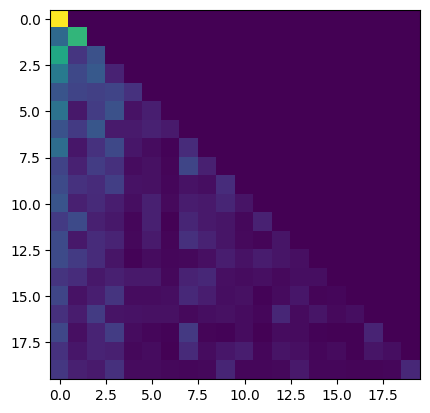

torch.Size([16, 20, 20])


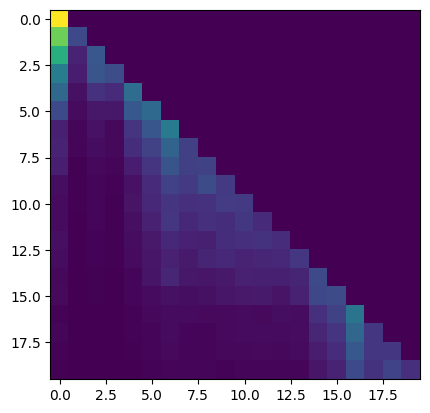

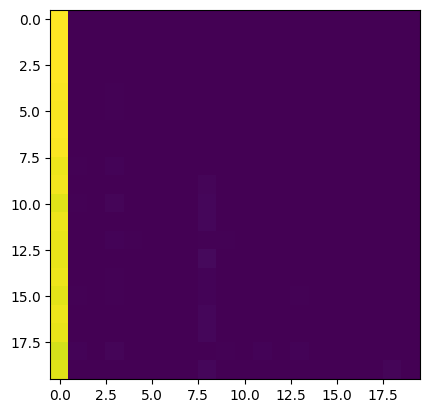

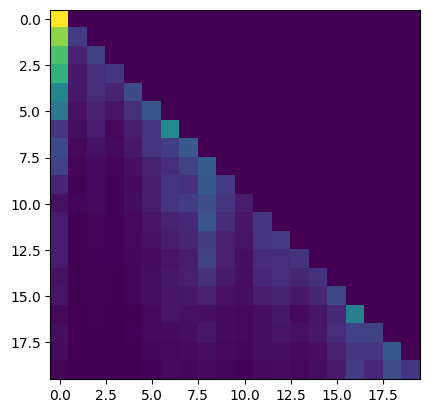

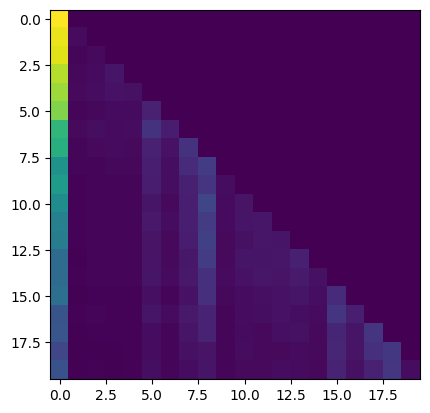

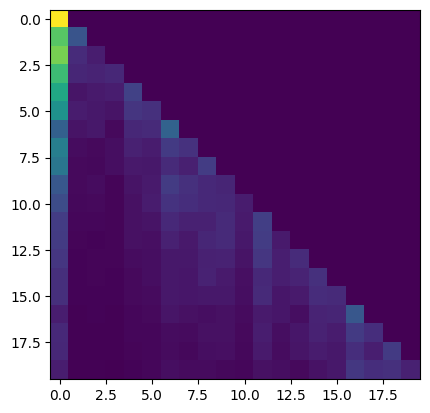

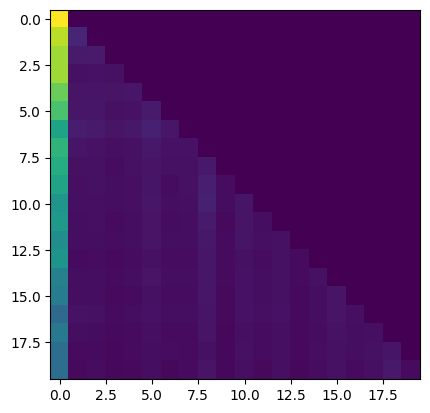

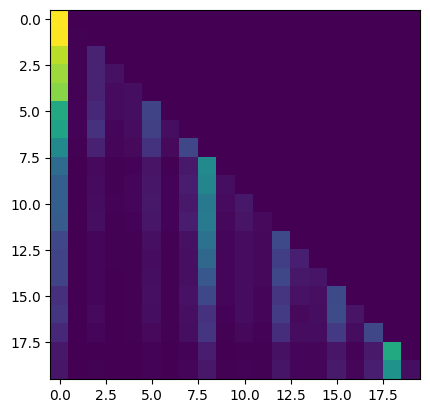

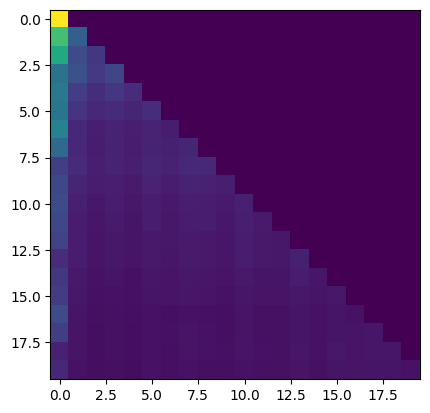

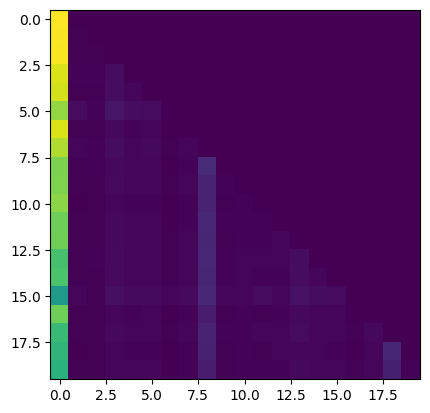

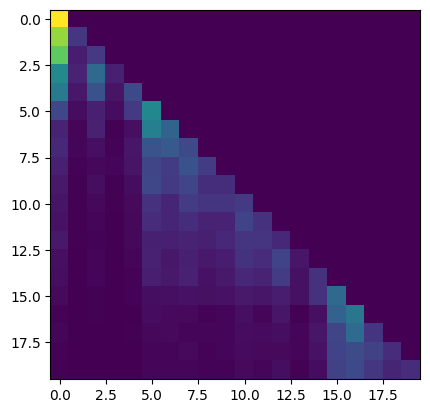

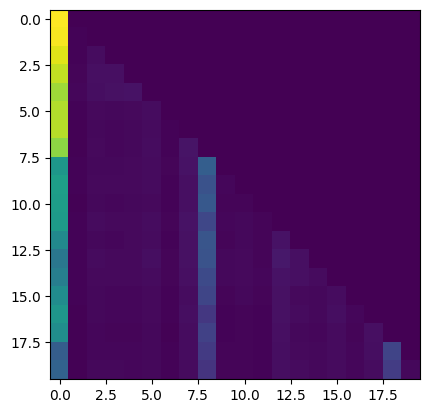

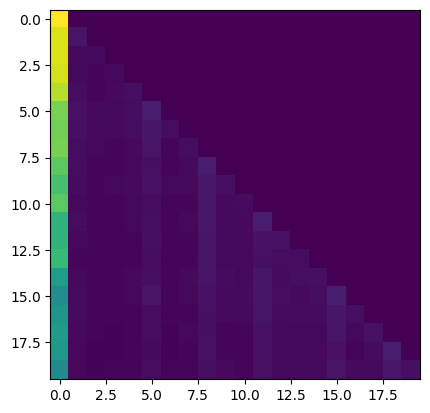

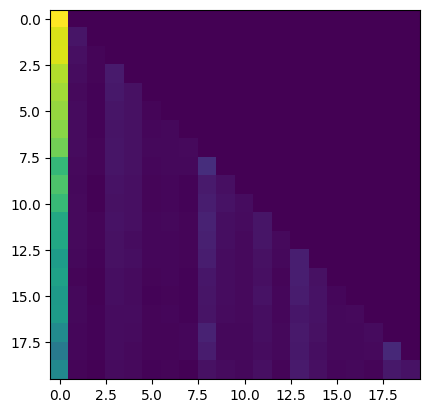

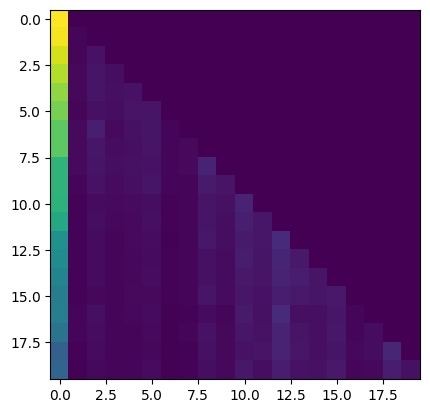

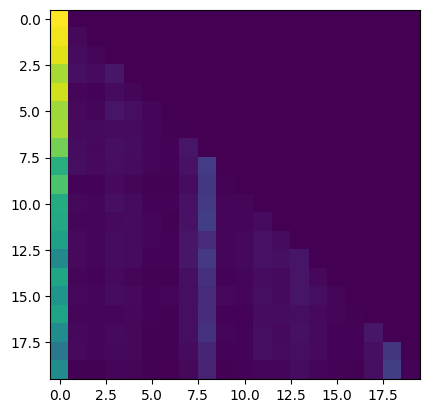

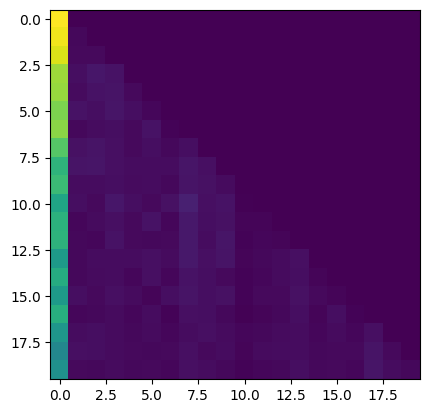

torch.Size([16, 20, 20])


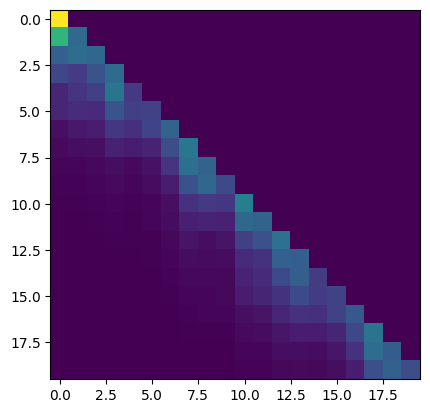

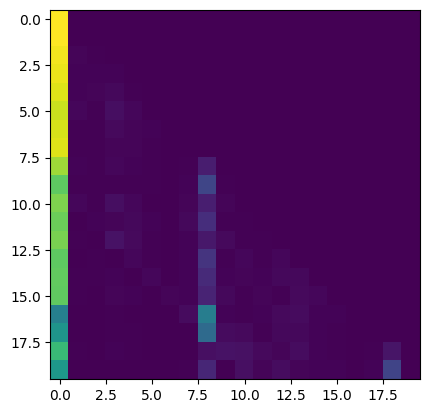

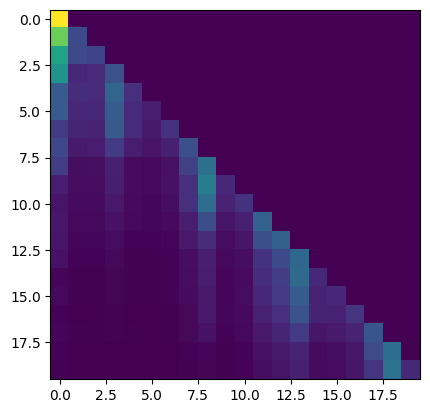

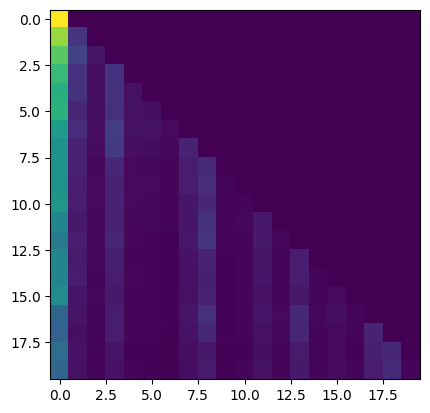

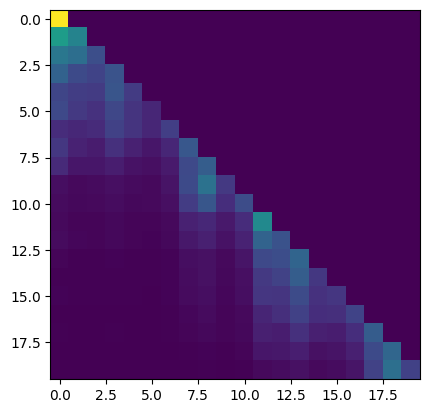

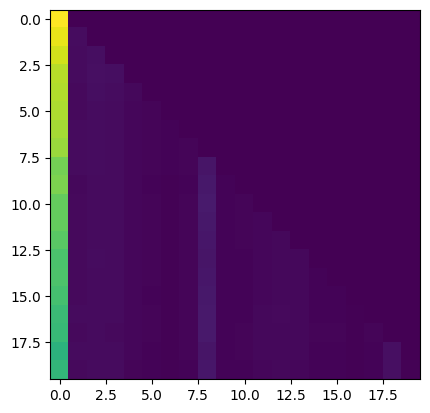

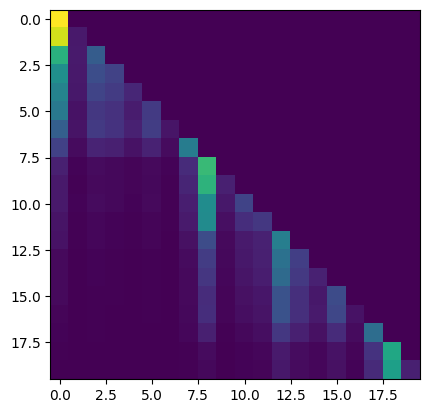

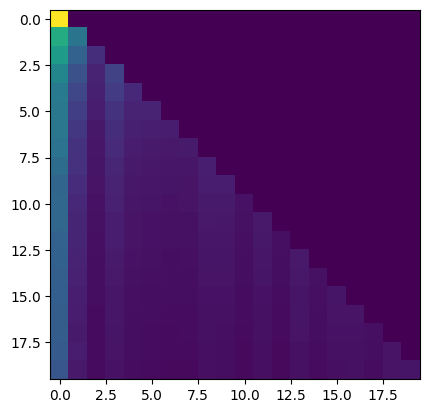

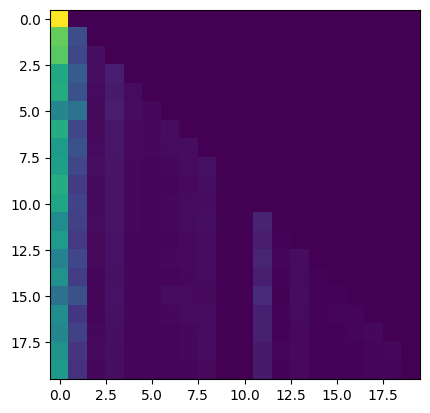

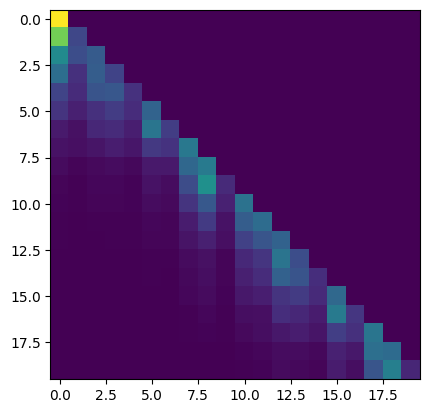

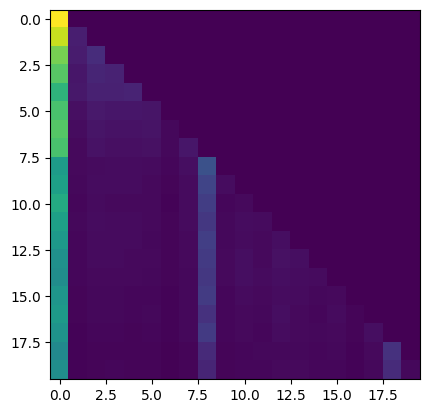

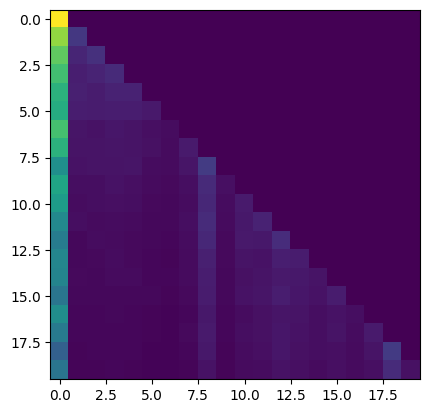

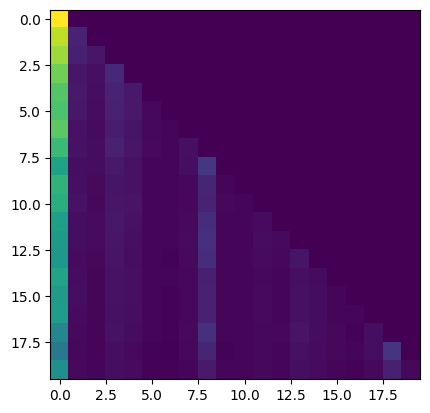

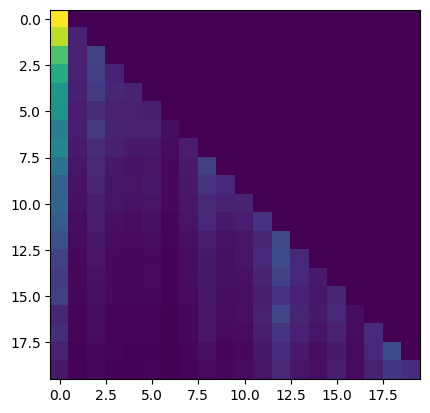

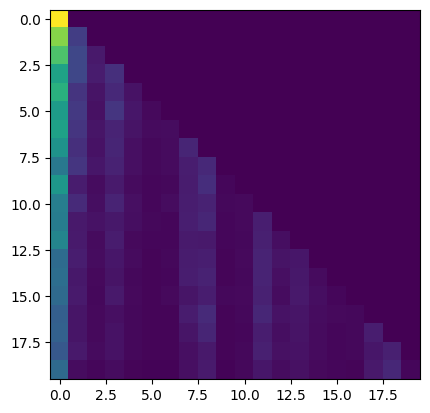

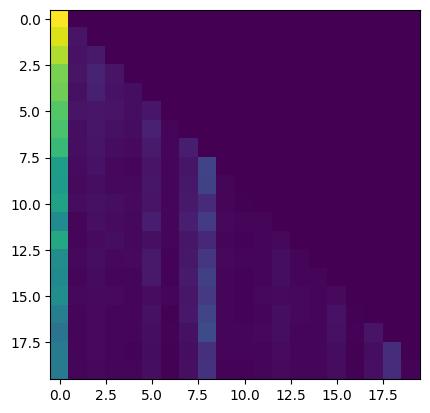

torch.Size([16, 20, 20])


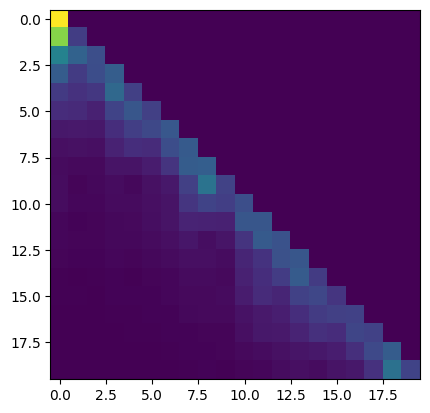

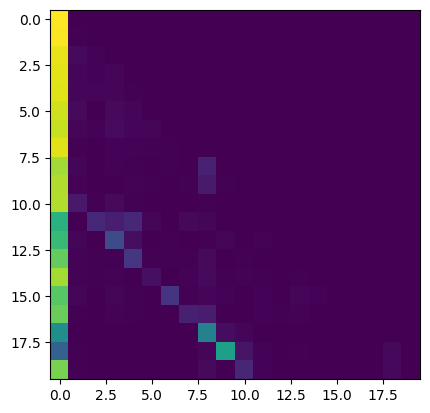

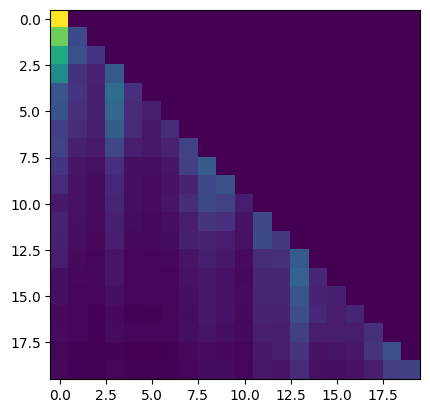

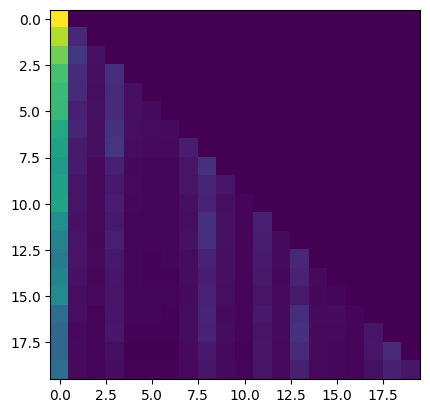

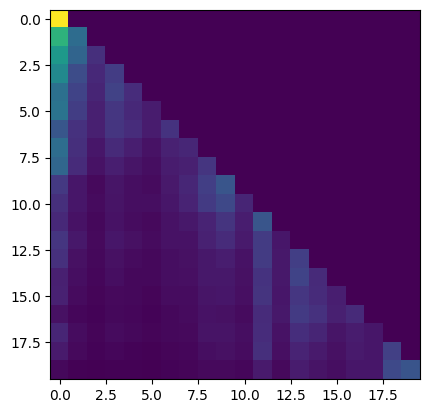

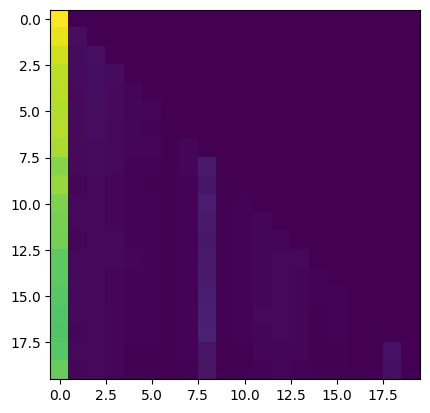

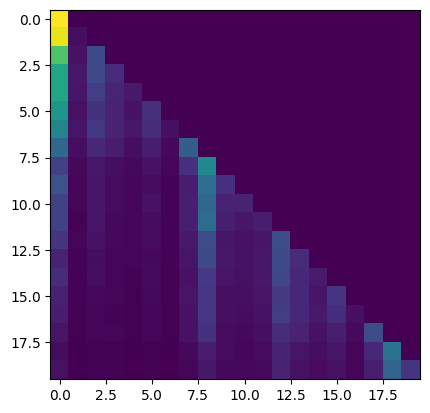

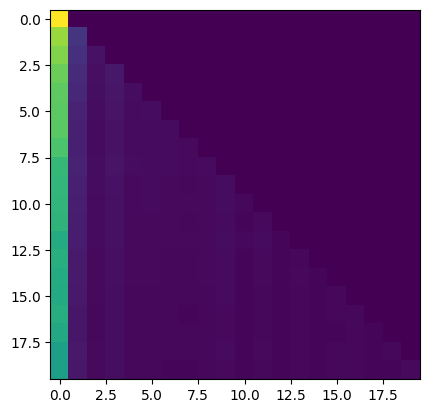

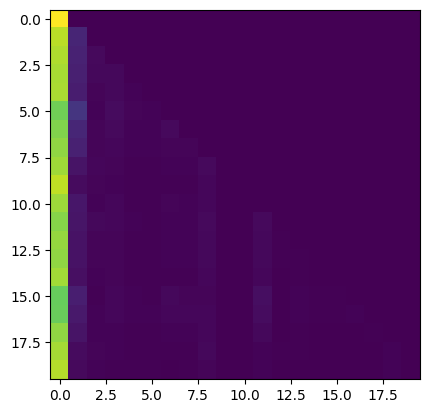

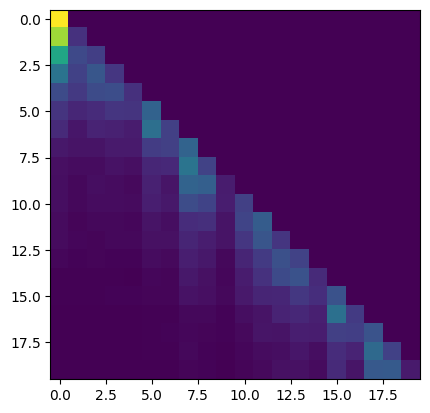

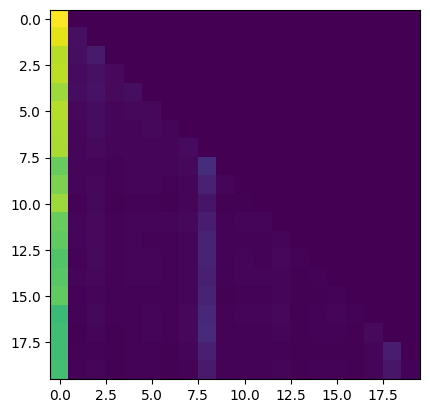

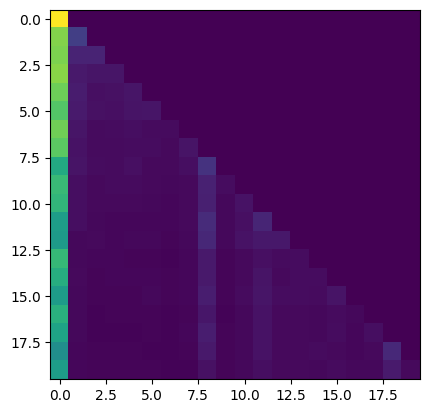

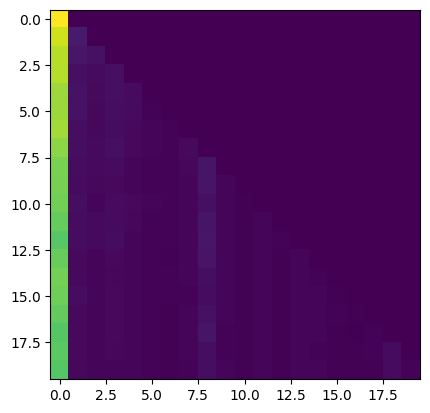

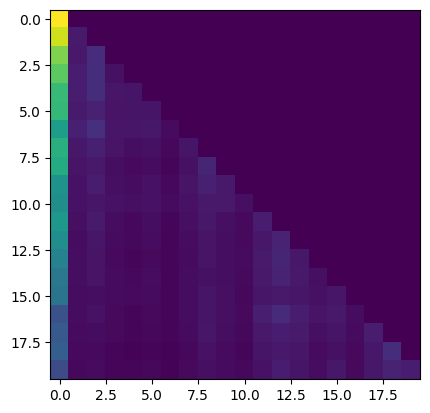

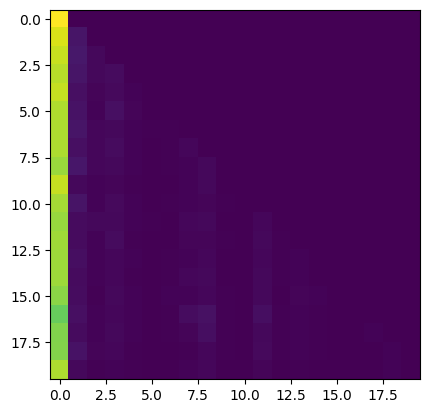

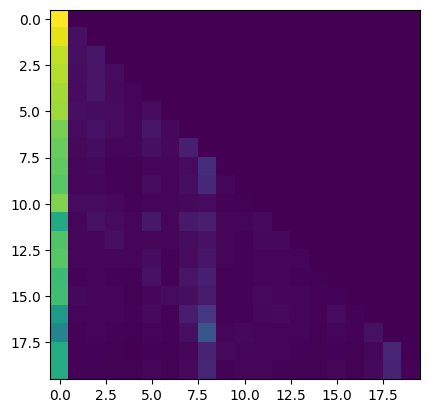

torch.Size([16, 20, 20])


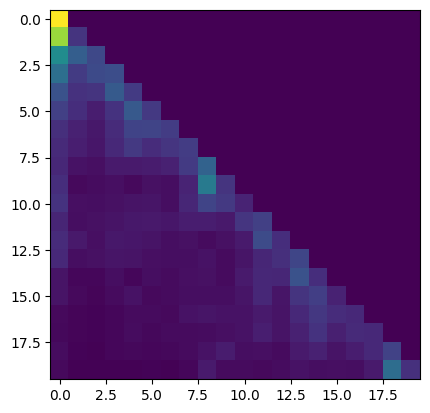

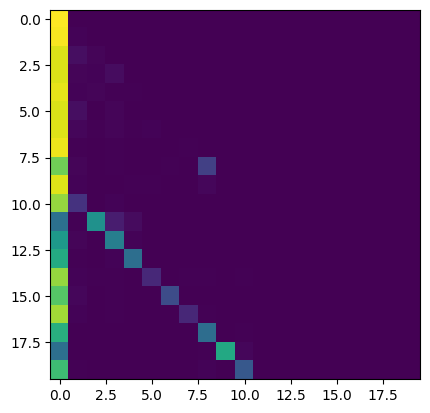

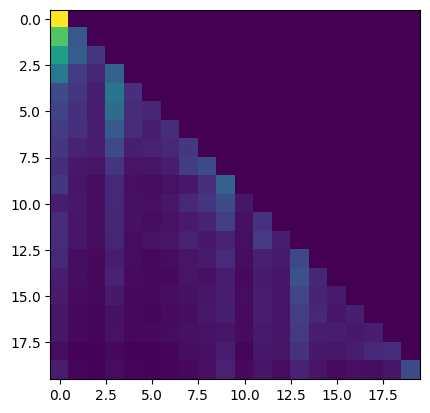

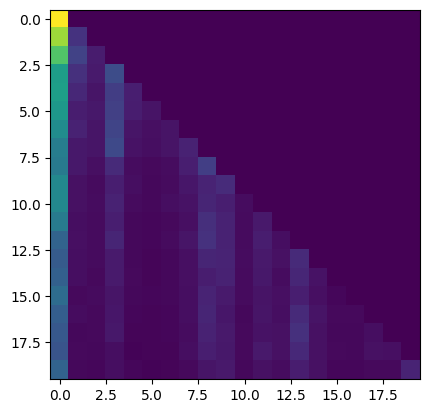

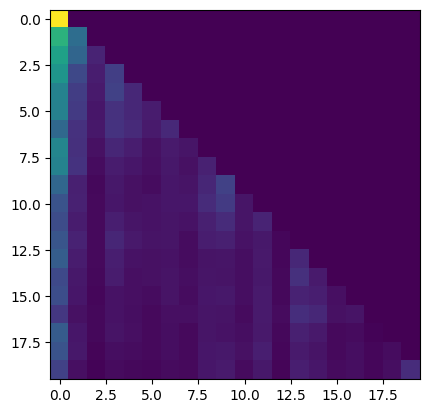

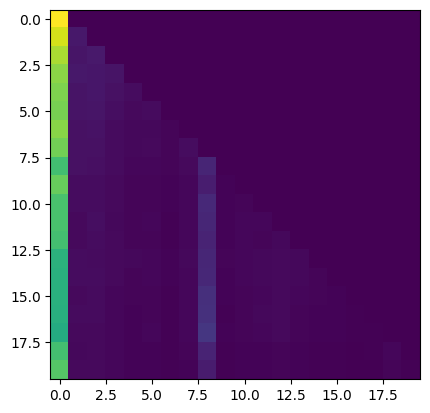

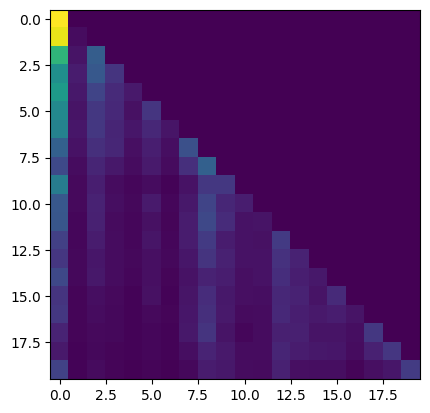

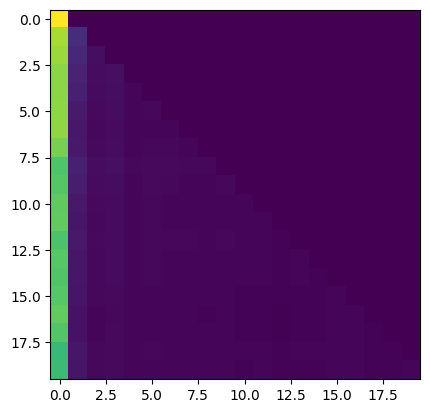

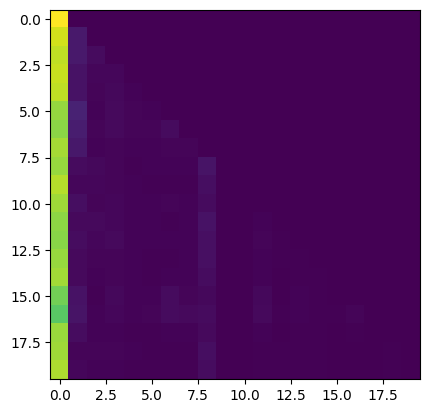

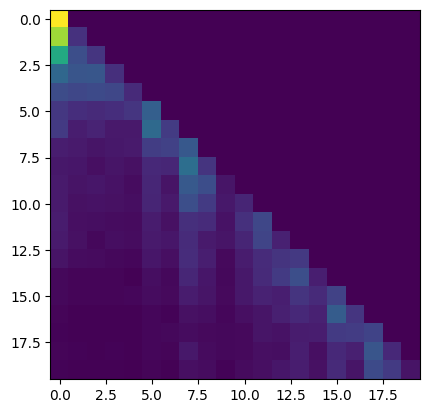

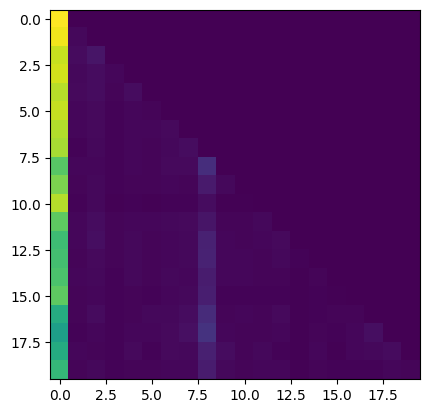

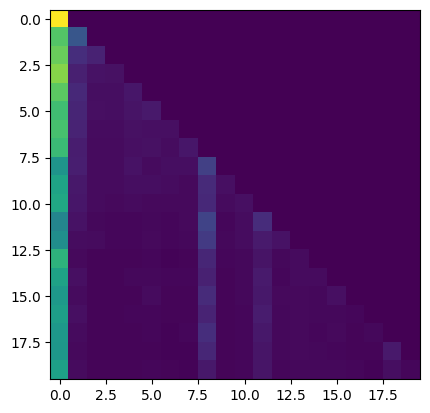

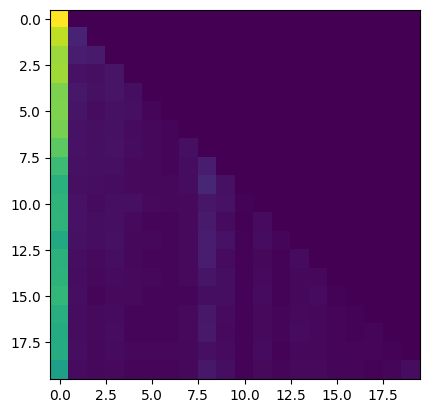

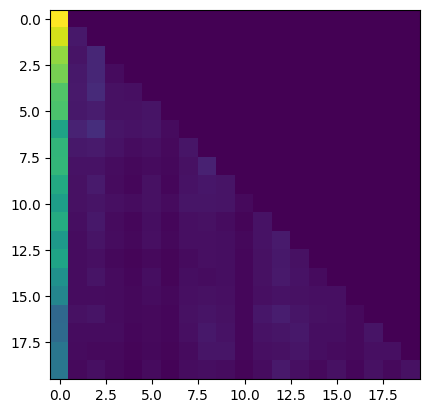

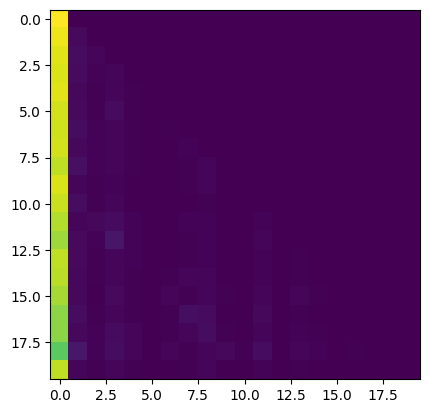

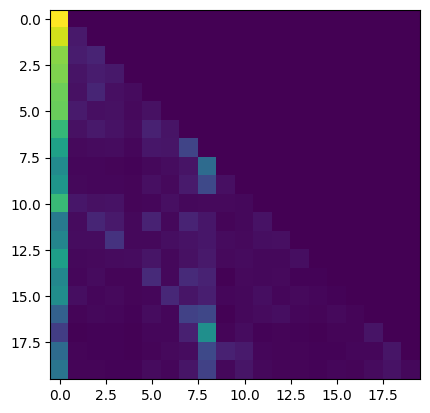

torch.Size([16, 20, 20])


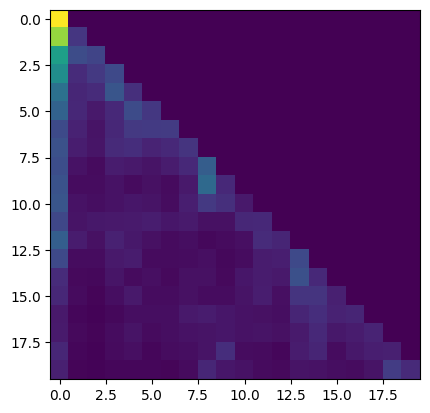

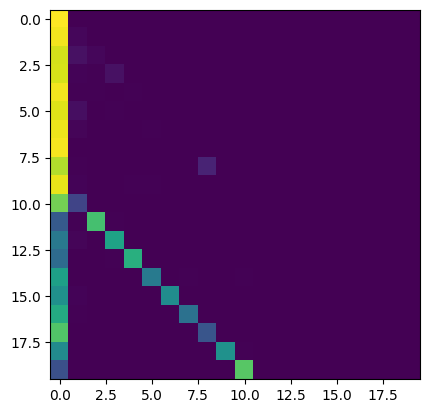

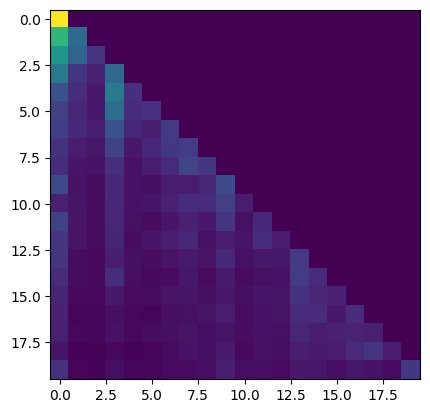

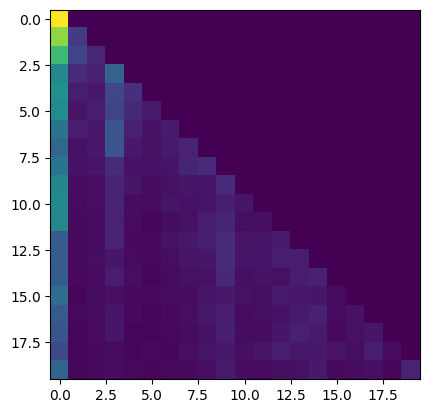

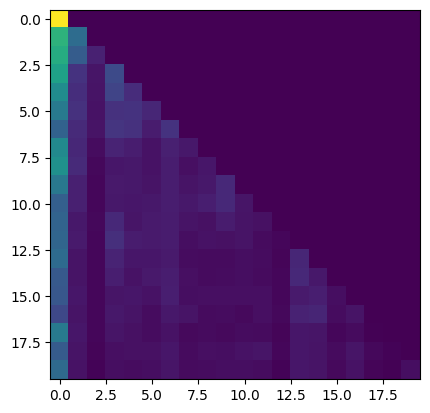

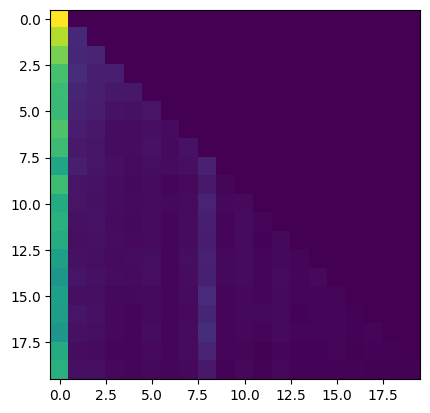

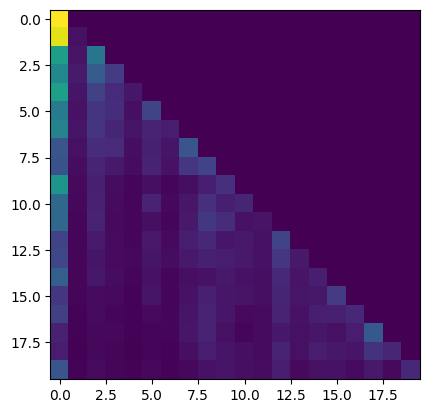

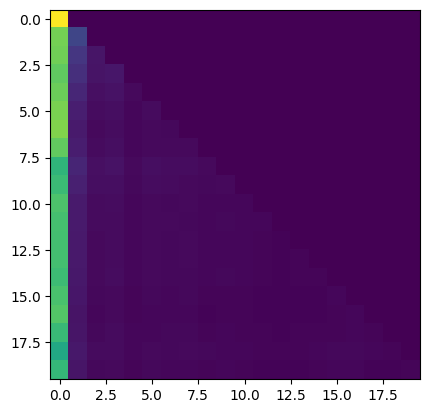

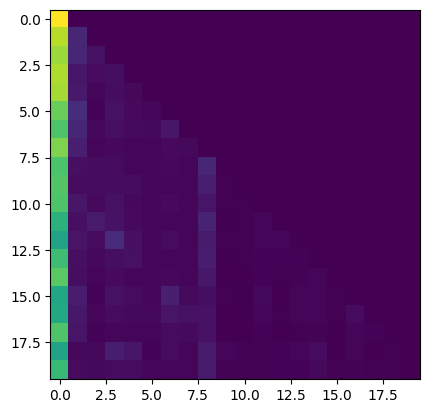

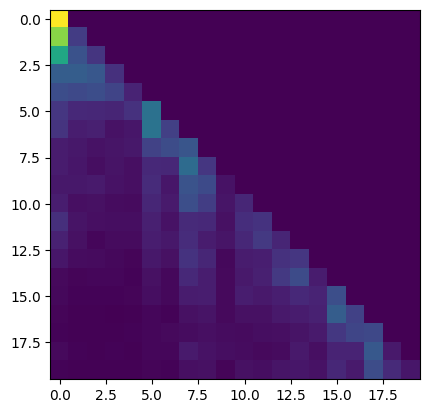

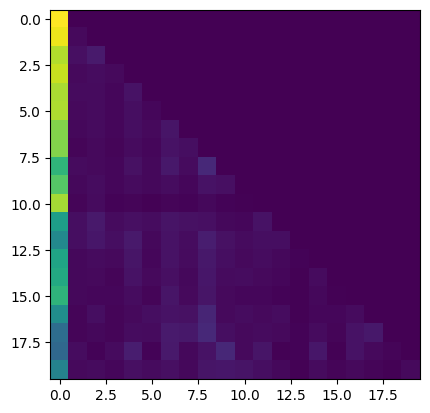

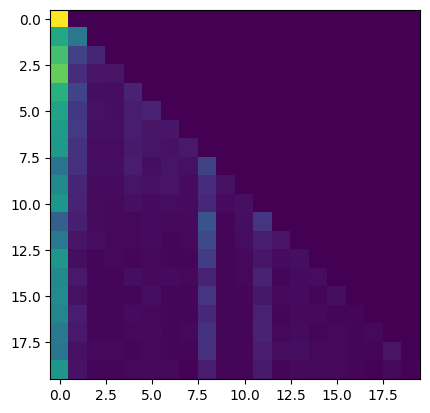

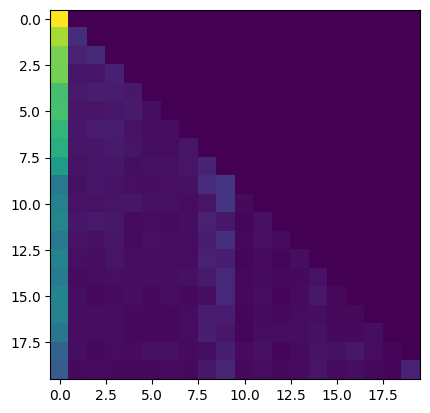

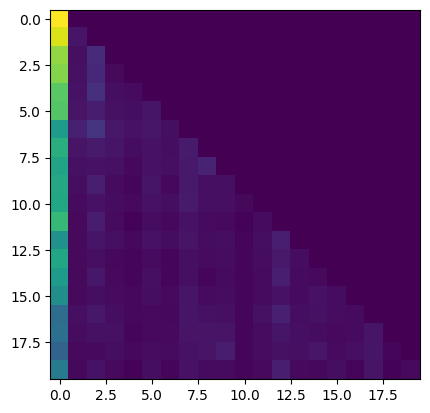

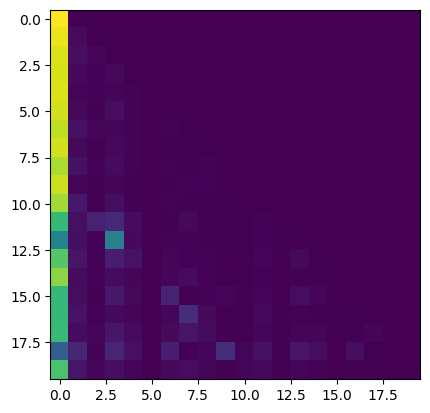

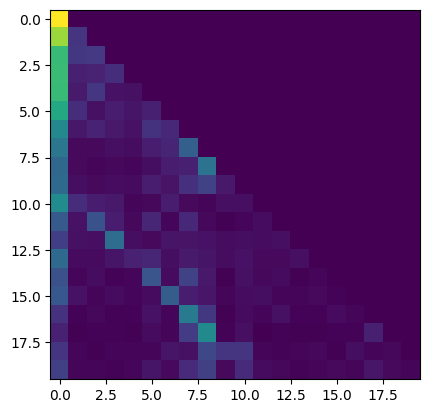

torch.Size([16, 20, 20])


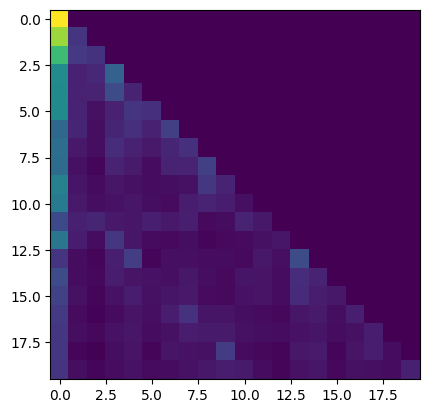

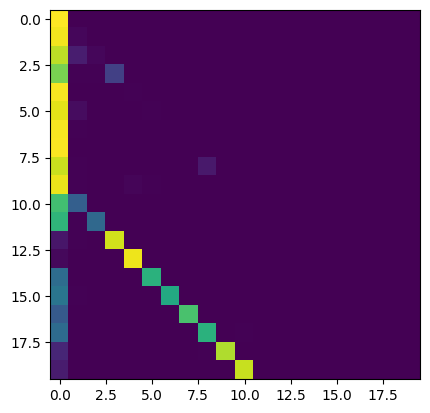

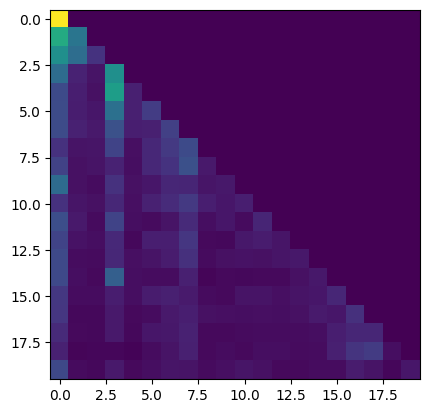

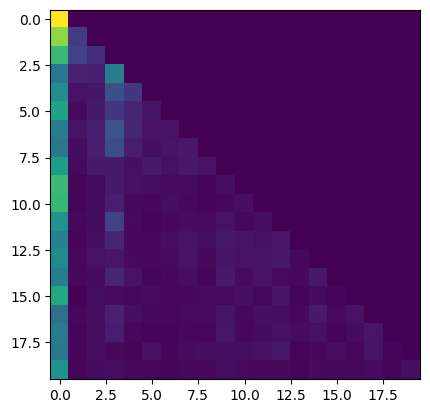

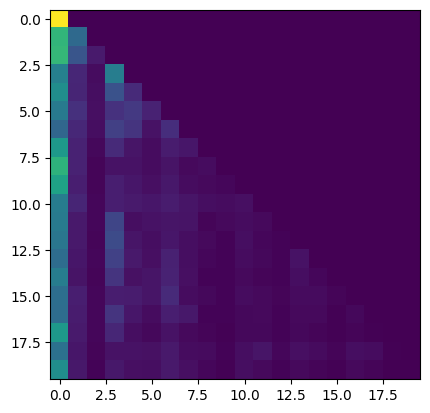

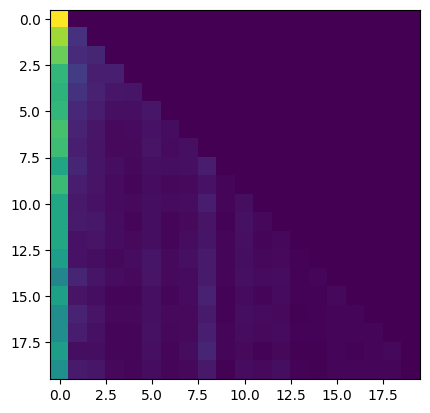

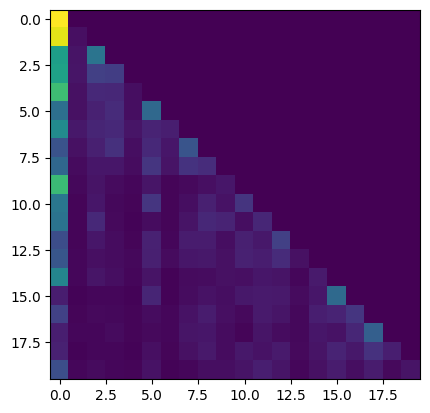

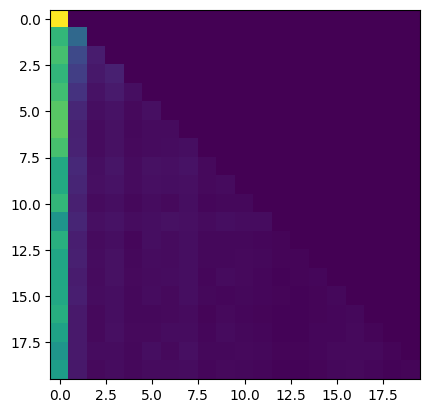

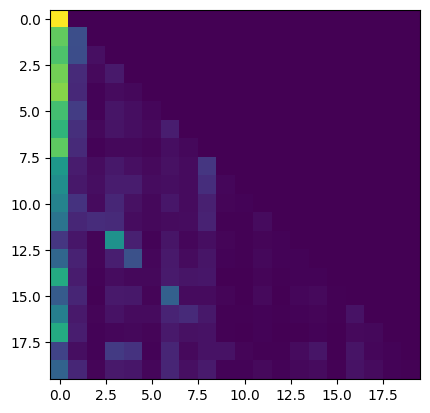

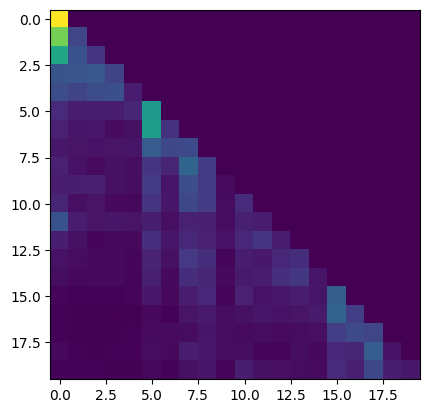

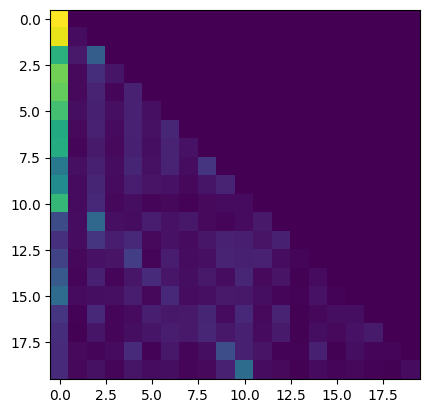

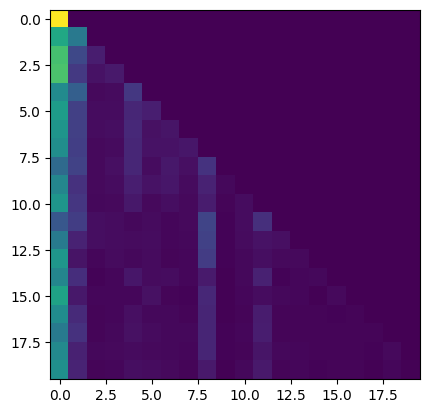

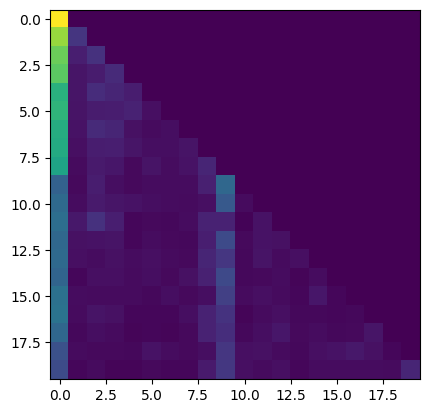

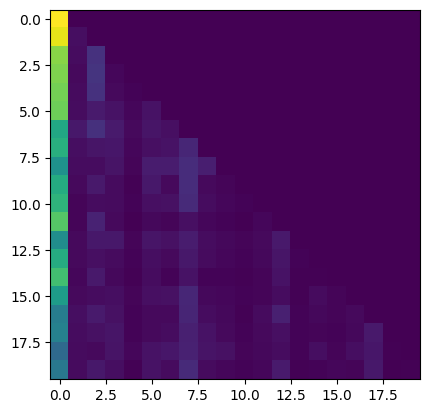

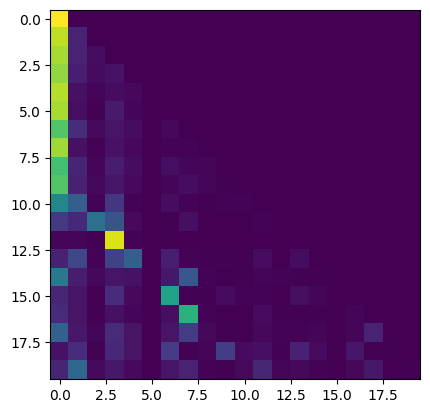

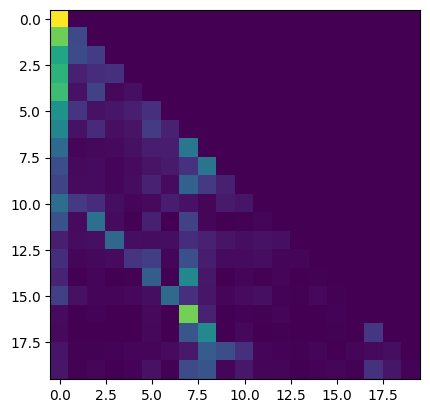

torch.Size([16, 20, 20])


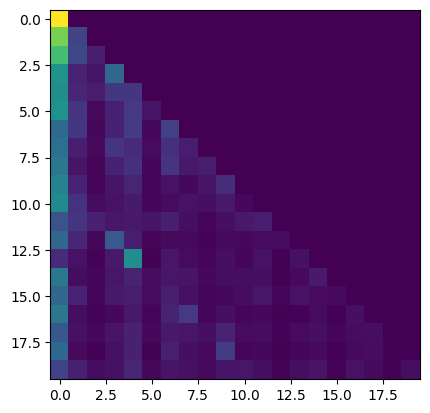

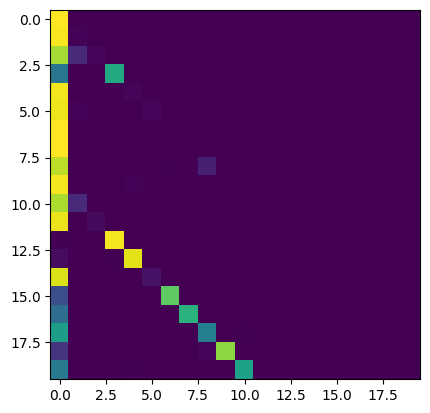

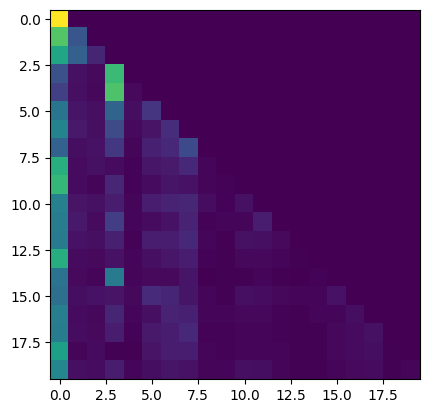

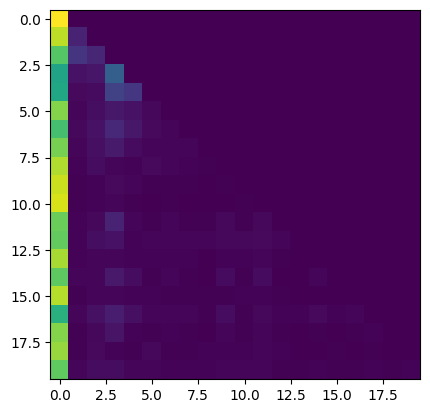

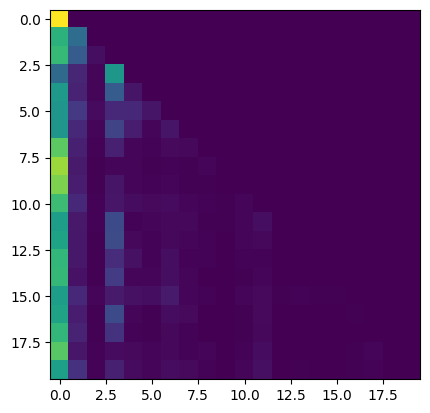

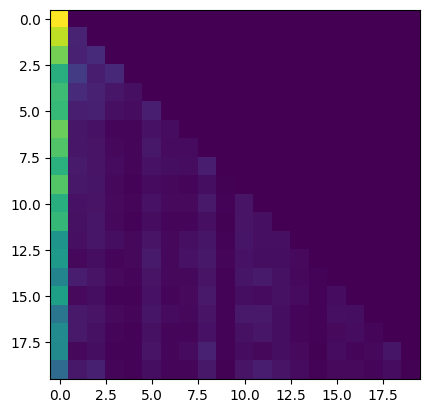

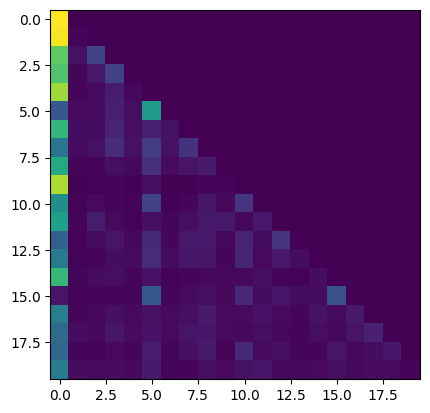

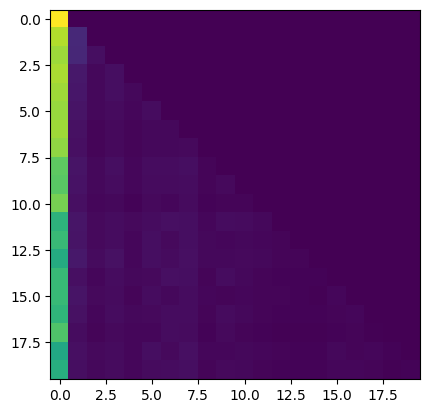

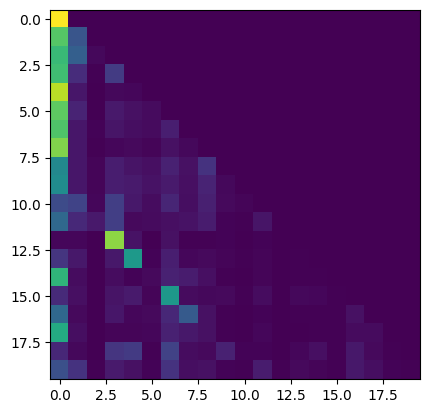

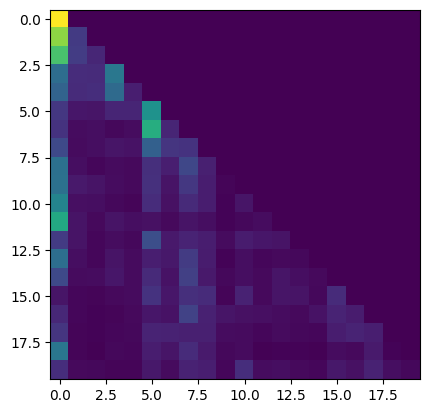

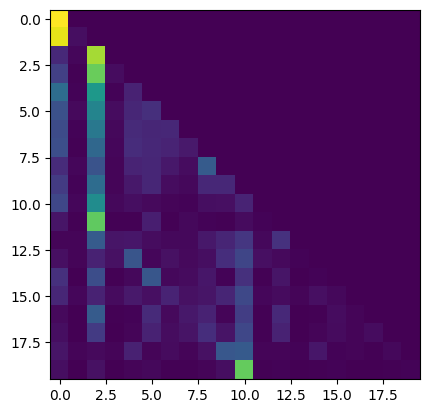

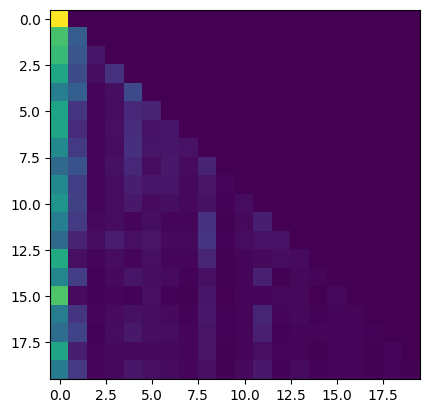

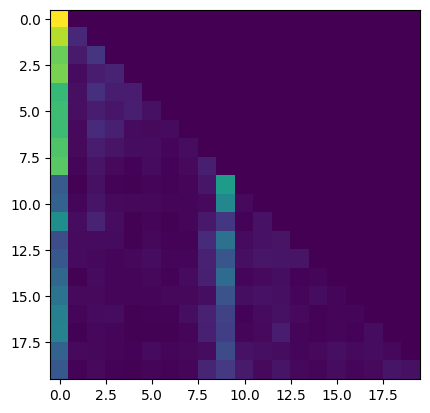

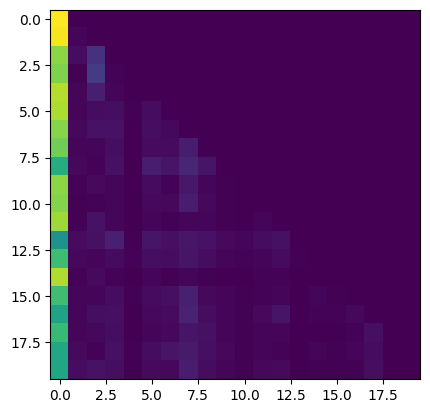

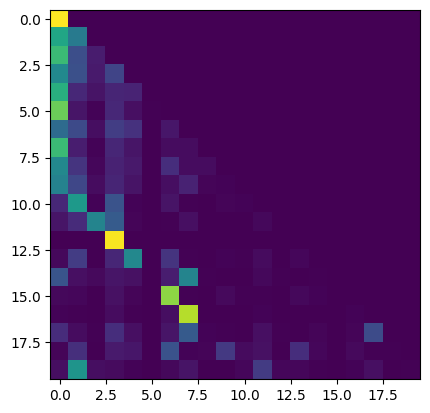

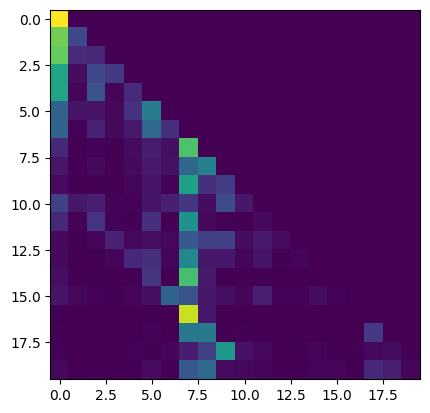

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [3]:
output = model(tokens)
# choose the highest probability token
next_token = torch.argmax(output[0][-1])
# tokens = torch.cat([tokens, next_token], dim=1)
print(tokenizers.GPTTokenizer().ids_to_text(torch.cat([tokens[0], next_token.unsqueeze(0)]).unsqueeze(0)))
#tokens = torch.cat([tokens[0], next_token.unsqueeze(0)]).unsqueeze(0)

In [70]:
model.eval()
# generate 100 random tokens with seed 42
torch.manual_seed(41)
tokens = torch.randint(0, VOCAB_SIZE, (1, 20), dtype=torch.long)
tokens = torch.cat([tokens, tokens], dim=1)
tokens = tokens[:, :29]
output = model(tokens)
next_token = torch.argmax(output[0][-1])
print(next_token.unsqueeze(0).shape)
print(tokens[0].shape)
print(tokenizers.GPTTokenizer().ids_to_text(torch.cat([tokens[0], next_token.unsqueeze(0)])))
print(tokenizers.GPTTokenizer().ids_to_text(next_token))

torch.Size([1])
torch.Size([29])
 rakeEthcloud Joshua Neanderness liberate Bike expectancyNamesBrownGES� multPDF GovernorRemJohnsonoller strategy rakeEthcloud Joshua Neanderness liberate Bike expectancyNames
Names


In [60]:
text = "2 + 2 = "
tokens = tokenizers.GPTTokenizer().text_to_ids(text)
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0)
model.eval()
output = model(tokens)
next_token = torch.argmax(output[0][-1])
tokens = torch.cat([tokens[0], next_token.unsqueeze(0)])
print(tokenizers.GPTTokenizer().ids_to_text(tokens))

torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
torch.Size([1, 16, 5, 64])
2 + 2 =.
